In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

# Setup

In [49]:
df = pd.read_csv("data/results/time_data.csv", sep=";")
df["time"] = pd.to_datetime(df["time"])

C:\Users\Jefferson\AppData\Local\Temp\ipykernel_4540\3960761302.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["time"] = pd.to_datetime(df["time"])


In [50]:
class FloodDataset(Dataset):
    def __init__(self, data, sequence_length, predict_ahead):
        self.data = data
        self.sequence_length = sequence_length
        self.predict_ahead = predict_ahead

    def __len__(self):
        # Ensure length is non-negative
        return max(0, len(self.data) - self.sequence_length - self.predict_ahead + 1)

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self):
            raise IndexError(f"Index {idx} is out of bounds for dataset of size {len(self)}")
        
        # Input sequence: rain_gauge_1 and rain_gauge_2 for the past `sequence_length` time steps
        x = self.data[idx:idx+self.sequence_length, :-1]
        
        y = self.data[idx+self.sequence_length + self.predict_ahead - 1, -1]
        
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        
        return x, y

In [51]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Flatten the input sequence
        x = x.view(x.size(0), -1)  # Flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

In [52]:
def collate_fn(batch):
    # Separate inputs and labels
    inputs, labels = zip(*batch)
    
    # Pad the input sequences to the same length
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    
    # Stack the labels into a single tensor
    labels = torch.stack(labels)
    
    return inputs_padded, labels

In [53]:
def print_class_distribution(data, dataset_name):
    class_counts = np.unique(data[:, -1], return_counts=True)
    print(f"Class distribution in {dataset_name}:")
    for class_label, count in zip(class_counts[0], class_counts[1]):
        print(f"Class {int(class_label)}: {count} examples")

In [54]:
def evalute_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.squeeze().cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Flood", "Flood"], yticklabels=["No Flood", "Flood"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    class_report = classification_report(all_labels, all_predictions, target_names=["No Flood", "Flood"])
    print("\nClassification Report:\n", class_report)

In [78]:
def train_evaluate_mlp(train_dataloader, test_dataloader, hidden_size=64, sequence_length=6, criterion=nn.BCELoss()):
    input_size = sequence_length * 2 # Since there are two rain gauges
    output_size = 1  # Binary classification (Flood or No Flood)

    model = MLP(input_size, hidden_size, output_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 50

    for _ in range(num_epochs):
        model.train()
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

    evalute_model(model, test_dataloader)

    return model

In [79]:
data = df[["812A", "833A", "flood"]].values

sequence_length = 6
predict_ahead = 1

X = data[:, :-1]  # Features: rain_gauge_1, rain_gauge_2
y = data[:, -1]   # Labels: flood_boolean

data = np.hstack([X, y.reshape(-1,1)])

train_size = int(len(data) * 0.70)
train_data = data[:train_size]
test_data = data[train_size:]

print_class_distribution(train_data, "training data")

Class distribution in training data:
Class 0: 8656 examples
Class 1: 416 examples


In [81]:
test_dataset = FloodDataset(test_data, sequence_length, predict_ahead)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Dados desbalanceados

In [80]:
train_dataset = FloodDataset(train_data, sequence_length, predict_ahead)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

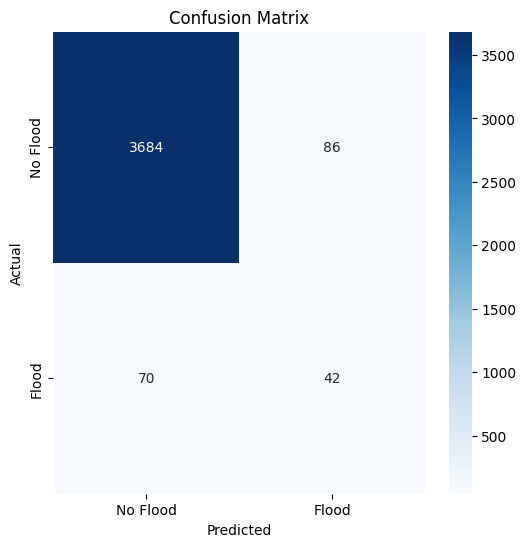


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.98      0.98      0.98      3770
       Flood       0.33      0.38      0.35       112

    accuracy                           0.96      3882
   macro avg       0.65      0.68      0.66      3882
weighted avg       0.96      0.96      0.96      3882



MLP(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [64]:
train_evaluate_mlp(train_dataloader, test_dataloader)

# Oversample

In [73]:
def oversample_minority_class_smote(data):
    X = data[:, :-1]
    y = data[:, -1]

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    balanced_data = np.hstack([X_resampled, y_resampled.reshape(-1, 1)])

    return balanced_data

In [82]:
train_data_oversampled = oversample_minority_class_smote(train_data)

print_class_distribution(train_data_oversampled, "oversampled training data")

Class distribution in oversampled training data:
Class 0: 8656 examples
Class 1: 8656 examples


In [83]:
train_dataset_oversampled = FloodDataset(train_data_oversampled, sequence_length, predict_ahead)
train_dataloader_oversampled = DataLoader(train_dataset_oversampled, batch_size=32, shuffle=True, collate_fn=collate_fn)

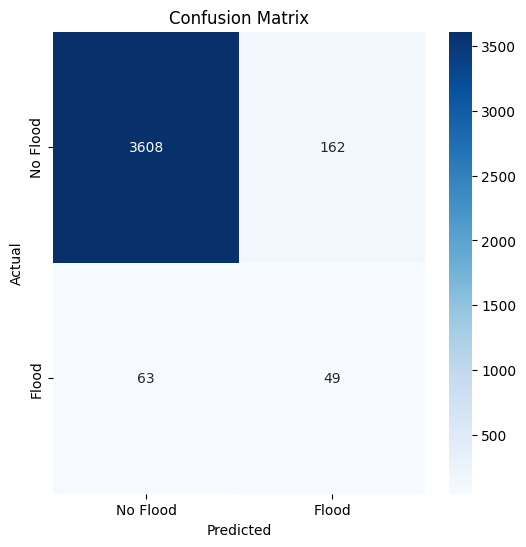


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.98      0.96      0.97      3770
       Flood       0.23      0.44      0.30       112

    accuracy                           0.94      3882
   macro avg       0.61      0.70      0.64      3882
weighted avg       0.96      0.94      0.95      3882



MLP(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [85]:
train_evaluate_mlp(train_dataloader_oversampled, test_dataloader)

# Treinamento com pesos nas classes

In [86]:
train_df = df[:train_size]

num_negatives = len(train_df[train_df["flood"] == 0])
num_positives = len(train_df[train_df["flood"] == 1])

pos_weight = torch.tensor([num_negatives/num_positives])
weighted_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

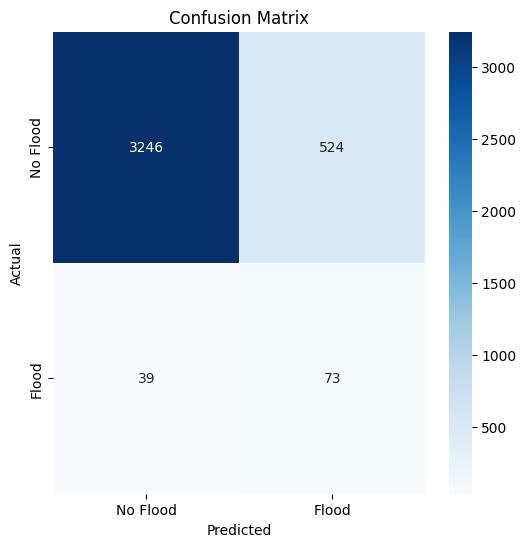


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.86      0.92      3770
       Flood       0.12      0.65      0.21       112

    accuracy                           0.85      3882
   macro avg       0.56      0.76      0.56      3882
weighted avg       0.96      0.85      0.90      3882



MLP(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [87]:
train_evaluate_mlp(train_dataloader, test_dataloader, criterion=weighted_criterion)